# **Local Lung Segmentation with Reduced Dataset**

## **Mô tả bài toán**
Phân vùng vùng tổn thương trên ảnh X-quang là bài toán trọng yếu trong chẩn đoán hình ảnh y học. Notebook này được thiết kế để chạy trên môi trường local với dataset đã được giảm kích thước.

## **Dataset**
Bộ dữ liệu đã được xử lý và giảm kích thước:
- **226 ảnh X-quang ngực** trong thư mục train/
- **Mask phân vùng** tương ứng cho từng ảnh
- **Chia train/validation**: 90/10 (203 train / 23 validation)
- **Test set**: Được ẩn đi, chỉ sử dụng train set
- **Định dạng**: PNG (ảnh RGB, mask grayscale)

## **Cấu hình**
- **Kích thước ảnh**: 256x256
- **Batch size**: 4
- **Epochs**: 10 (quick experiment)
- **Learning rate**: 0.001
- **Output**: /media/nghia/Nguyen NghiaW/Lung/results/


## **1. Import thư viện**


In [26]:
# Import các thư viện cần thiết
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import random
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Import cho XAI
from captum.attr import IntegratedGradients
from captum.attr._core.layer.grad_cam import LayerGradCam

# Thiết lập device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Sử dụng device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Sử dụng device: cuda
CUDA available: True
GPU: NVIDIA GeForce RTX 3090


## **2. Cấu hình và đường dẫn**


In [2]:
# Cấu hình hyperparameters
IMAGE_SIZE = 256
BATCH_SIZE = 4
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
TRAIN_SPLIT = 0.9  # 90% train
VAL_SPLIT = 0.1    # 10% validation

# Đường dẫn local
DATA_DIR = "/media/nghia/Nguyen NghiaW/Lung/chest-xray-masks-and-labels/Lung Segmentation"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
IMAGES_DIR = os.path.join(TRAIN_DIR, "CXR_png")
MASKS_DIR = os.path.join(TRAIN_DIR, "masks")
OUTPUT_DIR = "/media/nghia/Nguyen NghiaW/Lung/results"

print(f"Cấu hình:")
print(f"- Dataset path: {DATA_DIR}")
print(f"- Train directory: {TRAIN_DIR}")
print(f"- Images directory: {IMAGES_DIR}")
print(f"- Masks directory: {MASKS_DIR}")
print(f"- Output directory: {OUTPUT_DIR}")
print(f"- Kích thước ảnh: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Số epochs: {NUM_EPOCHS}")
print(f"- Learning rate: {LEARNING_RATE}")
print(f"- Train/Val split: {TRAIN_SPLIT}/{VAL_SPLIT}")


Cấu hình:
- Dataset path: /media/nghia/Nguyen NghiaW/Lung/chest-xray-masks-and-labels/Lung Segmentation
- Train directory: /media/nghia/Nguyen NghiaW/Lung/chest-xray-masks-and-labels/Lung Segmentation/train
- Images directory: /media/nghia/Nguyen NghiaW/Lung/chest-xray-masks-and-labels/Lung Segmentation/train/CXR_png
- Masks directory: /media/nghia/Nguyen NghiaW/Lung/chest-xray-masks-and-labels/Lung Segmentation/train/masks
- Output directory: /media/nghia/Nguyen NghiaW/Lung/results
- Kích thước ảnh: 256x256
- Batch size: 4
- Số epochs: 10
- Learning rate: 0.001
- Train/Val split: 0.9/0.1


## **3. Kiểm tra dataset**


In [3]:
# Kiểm tra dataset và tạo thư mục output
if os.path.exists(TRAIN_DIR) and os.path.exists(IMAGES_DIR) and os.path.exists(MASKS_DIR):
    print("✅ Dataset đã sẵn sàng!")
    print(f"📁 Train directory: {TRAIN_DIR}")
    print(f"📁 Images directory: {IMAGES_DIR}")
    print(f"📁 Masks directory: {MASKS_DIR}")
    
    # Đếm số ảnh và mask
    image_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith('.png')]
    mask_files = [f for f in os.listdir(MASKS_DIR) if f.endswith('.png')]
    
    print(f"📸 Tổng số ảnh: {len(image_files)}")
    print(f"🎭 Tổng số mask: {len(mask_files)}")
    
    # Tạo thư mục output
    os.makedirs(f'{OUTPUT_DIR}/models', exist_ok=True)
    os.makedirs(f'{OUTPUT_DIR}/plots', exist_ok=True)
    os.makedirs(f'{OUTPUT_DIR}/predictions', exist_ok=True)
    os.makedirs(f'{OUTPUT_DIR}/gradcam', exist_ok=True)
    print(f"📦 Thư mục output đã được tạo tại: {OUTPUT_DIR}")
else:
    print("❌ Dataset không tồn tại hoặc sai cấu trúc!")
    print("Hãy kiểm tra lại đường dẫn dataset.")


✅ Dataset đã sẵn sàng!
📁 Train directory: /media/nghia/Nguyen NghiaW/Lung/chest-xray-masks-and-labels/Lung Segmentation/train
📁 Images directory: /media/nghia/Nguyen NghiaW/Lung/chest-xray-masks-and-labels/Lung Segmentation/train/CXR_png
📁 Masks directory: /media/nghia/Nguyen NghiaW/Lung/chest-xray-masks-and-labels/Lung Segmentation/train/masks
📸 Tổng số ảnh: 226
🎭 Tổng số mask: 226
📦 Thư mục output đã được tạo tại: /media/nghia/Nguyen NghiaW/Lung/results


## **4. Dataset Class và Train/Val Split**


In [4]:
class ChestXrayDataset(Dataset):
    """Dataset cho ảnh X-quang ngực và mask"""

    def __init__(self, image_files, transform=None, is_training=True):
        self.image_files = image_files
        self.transform = transform
        self.is_training = is_training

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Đường dẫn file ảnh
        image_filename = self.image_files[idx]
        image_path = os.path.join(IMAGES_DIR, image_filename)

        # Tạo tên file mask tương ứng
        mask_filename = image_filename.replace(".png", "_mask.png")
        mask_path = os.path.join(MASKS_DIR, mask_filename)

        # Đọc ảnh và mask
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Nếu mask không tồn tại -> báo lỗi rõ ràng
        if mask is None:
            raise FileNotFoundError(f"Không tìm thấy mask tương ứng: {mask_path}")

        # Resize về kích thước chuẩn
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))

        # Chuẩn hóa mask về [0, 1]
        mask = mask / 255.0

        # Áp dụng augmentations nếu có
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Chuyển đổi sang tensor
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask

# Data augmentation cho training
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

# Không có augmentation cho validation
val_transform = None

# Lấy toàn bộ danh sách ảnh .png từ train folder
all_images = sorted([f for f in os.listdir(IMAGES_DIR) if f.endswith('.png')])

# Giữ lại những ảnh có mask tương ứng
valid_images = []
for img in all_images:
    mask_path = os.path.join(MASKS_DIR, img.replace('.png', '_mask.png'))
    if os.path.exists(mask_path):
        valid_images.append(img)

print(f"🩻 Tổng số ảnh có mask hợp lệ: {len(valid_images)} / {len(all_images)}")

# Chia train / val với tỷ lệ 90/10
train_files, val_files = train_test_split(valid_images, test_size=VAL_SPLIT, random_state=42)

print("✅ Dữ liệu đã được chia:")
print(f"- Train: {len(train_files)} ảnh ({len(train_files)/len(valid_images)*100:.1f}%)")
print(f"- Val: {len(val_files)} ảnh ({len(val_files)/len(valid_images)*100:.1f}%)")
print(f"- Random state: 42 (reproducible)")

# Tạo datasets và DataLoaders
train_dataset = ChestXrayDataset(train_files, transform=train_transform, is_training=True)
val_dataset = ChestXrayDataset(val_files, transform=val_transform, is_training=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"DataLoader đã được tạo:")
print(f"- Train batches: {len(train_loader)}")
print(f"- Validation batches: {len(val_loader)}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Workers: 2")


🩻 Tổng số ảnh có mask hợp lệ: 226 / 226
✅ Dữ liệu đã được chia:
- Train: 203 ảnh (89.8%)
- Val: 23 ảnh (10.2%)
- Random state: 42 (reproducible)
DataLoader đã được tạo:
- Train batches: 51
- Validation batches: 6
- Batch size: 4
- Workers: 2


## **5. Định nghĩa mô hình U-Net**


In [5]:
# Định nghĩa mô hình U-Net đơn giản
class SimpleUNet(nn.Module):
    """U-Net architecture đơn giản cho segmentation"""
    
    def __init__(self, in_channels=3, out_channels=1):
        super(SimpleUNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.dec4 = self.conv_block(512 + 512, 512)
        self.dec3 = self.conv_block(256 + 256, 256)
        self.dec2 = self.conv_block(128 + 128, 128)
        self.dec1 = self.conv_block(64 + 64, 64)
        
        # Final layer
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
        # Pooling và upsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.up = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    
    def conv_block(self, in_channels, out_channels):
        """Block convolution với 2 lớp conv"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False),  # Tắt inplace cho GradCAM
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False)  # Tắt inplace cho GradCAM
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # Decoder với skip connections
        dec4 = self.up(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.up3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.up2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.up1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)
        
        # Output
        output = self.final(dec1)
        output = self.sigmoid(output)
        
        return output

# Tạo mô hình
model = SimpleUNet(in_channels=3, out_channels=1)
model = model.to(device)

print(f"Mô hình U-Net đã được tạo và chuyển đến {device}")
print(f"Số parameters: {sum(p.numel() for p in model.parameters()):,}")


Mô hình U-Net đã được tạo và chuyển đến cuda
Số parameters: 31,043,521


## **6. Loss Function, Optimizer và Training**


In [6]:
# Định nghĩa Dice Loss
class DiceLoss(nn.Module):
    """Dice Loss cho segmentation"""
    
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        # Flatten tensors
        pred = pred.view(-1)
        target = target.view(-1)
        
        # Tính intersection và union
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return 1 - dice

# Định nghĩa Combined Loss (Dice + BCE)
class CombinedLoss(nn.Module):
    """Kết hợp Dice Loss và Binary Cross Entropy Loss"""
    
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCELoss()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
    
    def forward(self, pred, target):
        dice = self.dice_loss(pred, target)
        bce = self.bce_loss(pred, target)
        return self.dice_weight * dice + self.bce_weight * bce

# Hàm tính metrics
def calculate_dice(pred, target, threshold=0.5):
    """Tính Dice Coefficient"""
    pred_binary = (pred > threshold).float()
    target_binary = target.float()
    
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum()
    
    dice = (2.0 * intersection) / (union + 1e-8)
    return dice.item()

def calculate_iou(pred, target, threshold=0.5):
    """Tính Intersection over Union (IoU)"""
    pred_binary = (pred > threshold).float()
    target_binary = target.float()
    
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection
    
    iou = intersection / (union + 1e-8)
    return iou.item()

def calculate_f1(pred, target, threshold=0.5):
    """Tính F1 score cho segmentation (nhị phân)"""
    pred_binary = (pred > threshold).int().cpu().numpy().flatten()
    target_binary = (target > threshold).int().cpu().numpy().flatten()
    
    # Xử lý trường hợp batch toàn 0 hoặc toàn 1 tránh lỗi sklearn
    if len(np.unique(target_binary)) == 1:
        return float(pred_binary.mean() == target_binary.mean())

    return f1_score(target_binary, pred_binary, average='binary')

def calculate_metrics(pred, target, threshold=0.5):
    """Tính tất cả metrics"""
    dice = calculate_dice(pred, target, threshold)
    iou = calculate_iou(pred, target, threshold)
    f1 = calculate_f1(pred, target, threshold)
    
    return {
        'dice': dice,
        'iou': iou,
        'f1': f1
    }

# Tạo loss function và optimizer
criterion = CombinedLoss(dice_weight=0.7, bce_weight=0.3)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

print("Loss function và optimizer đã được thiết lập:")
print(f"- Loss: Combined Loss (Dice: 0.7, BCE: 0.3)")
print(f"- Optimizer: Adam (lr={LEARNING_RATE})")
print(f"- Scheduler: ReduceLROnPlateau")


Loss function và optimizer đã được thiết lập:
- Loss: Combined Loss (Dice: 0.7, BCE: 0.3)
- Optimizer: Adam (lr=0.001)
- Scheduler: ReduceLROnPlateau


In [7]:
# Hàm training một epoch
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Training một epoch"""
    model.train()
    total_loss = 0
    total_dice = 0
    total_iou = 0
    total_f1 = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for batch_idx, (images, masks) in enumerate(progress_bar):
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Tính metrics
        with torch.no_grad():
            metrics = calculate_metrics(outputs, masks)
        
        total_loss += loss.item()
        total_dice += metrics['dice']
        total_iou += metrics['iou']
        total_f1 += metrics['f1']
        
        # Cập nhật progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Dice': f'{metrics["dice"]:.4f}'
        })
    
    avg_loss = total_loss / len(train_loader)
    avg_dice = total_dice / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    avg_f1 = total_f1 / len(train_loader)
    
    return avg_loss, avg_dice, avg_iou, avg_f1

# Hàm validation một epoch
def validate_epoch(model, val_loader, criterion, device):
    """Validation một epoch"""
    model.eval()
    total_loss = 0
    total_dice = 0
    total_iou = 0
    total_f1 = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation")
        
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Tính metrics
            metrics = calculate_metrics(outputs, masks)
            
            total_loss += loss.item()
            total_dice += metrics['dice']
            total_iou += metrics['iou']
            total_f1 += metrics['f1']
            
            # Cập nhật progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Dice': f'{metrics["dice"]:.4f}'
            })
    
    avg_loss = total_loss / len(val_loader)
    avg_dice = total_dice / len(val_loader)
    avg_iou = total_iou / len(val_loader)
    avg_f1 = total_f1 / len(val_loader)
    
    return avg_loss, avg_dice, avg_iou, avg_f1

print("Training và validation functions đã được định nghĩa")


Training và validation functions đã được định nghĩa


In [8]:
# Main training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs):
    """Huấn luyện mô hình"""
    
    # Lưu trữ lịch sử training
    train_losses = []
    val_losses = []
    train_dices = []
    val_dices = []
    train_ious = []
    val_ious = []
    train_f1s = []
    val_f1s = []
    
    best_val_dice = 0
    best_model_state = None
    
    print("Bắt đầu training...")
    print("=" * 60)
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 40)
        
        # Training
        train_loss, train_dice, train_iou, train_f1 = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Validation
        val_loss, val_dice, val_iou, val_f1 = validate_epoch(
            model, val_loader, criterion, device
        )
        
        # Cập nhật learning rate
        scheduler.step(val_loss)
        
        # Lưu trữ metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_dices.append(train_dice)
        val_dices.append(val_dice)
        train_ious.append(train_iou)
        val_ious.append(val_iou)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)
        
        # In kết quả
        print(f"Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}, F1: {train_f1:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, F1: {val_f1:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Lưu best model
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            best_model_state = model.state_dict().copy()
            print(f"✓ New best validation Dice: {best_val_dice:.4f}")
        
        print("=" * 60)
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Đã load best model với validation Dice: {best_val_dice:.4f}")
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_dices': train_dices,
        'val_dices': val_dices,
        'train_ious': train_ious,
        'val_ious': val_ious,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'best_val_dice': best_val_dice
    }

print("Training function đã được định nghĩa")


Training function đã được định nghĩa


## **7. Bắt đầu Training**


In [9]:
# Bắt đầu training
print(f"Bắt đầu training với cấu hình:")
print(f"- Số epochs: {NUM_EPOCHS}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Train samples: {len(train_files)}")
print(f"- Val samples: {len(val_files)}")
print(f"- Device: {device}")

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=NUM_EPOCHS
)


Bắt đầu training với cấu hình:
- Số epochs: 10
- Batch size: 4
- Train samples: 203
- Val samples: 23
- Device: cuda
Bắt đầu training...
Epoch 1/10
----------------------------------------


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.41it/s, Loss=0.2794, Dice=0.8634]


Train - Loss: 0.3419, Dice: 0.7942, IoU: 0.6748, F1: 0.7942
Val   - Loss: 0.2742, Dice: 0.8589, IoU: 0.7529, F1: 0.8590
Learning Rate: 0.001000
✓ New best validation Dice: 0.8589
Epoch 2/10
----------------------------------------


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.44it/s, Loss=0.3002, Dice=0.7573]


Train - Loss: 0.1702, Dice: 0.9017, IoU: 0.8233, F1: 0.9017
Val   - Loss: 0.2968, Dice: 0.7670, IoU: 0.6225, F1: 0.7670
Learning Rate: 0.001000
Epoch 3/10
----------------------------------------


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s, Loss=0.2551, Dice=0.8037]


Train - Loss: 0.1205, Dice: 0.9214, IoU: 0.8557, F1: 0.9214
Val   - Loss: 0.2534, Dice: 0.8073, IoU: 0.6773, F1: 0.8074
Learning Rate: 0.001000
Epoch 4/10
----------------------------------------


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.24it/s, Loss=0.0649, Dice=0.9555]


Train - Loss: 0.1128, Dice: 0.9191, IoU: 0.8527, F1: 0.9191
Val   - Loss: 0.0764, Dice: 0.9464, IoU: 0.8985, F1: 0.9465
Learning Rate: 0.001000
✓ New best validation Dice: 0.9464
Epoch 5/10
----------------------------------------


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.39it/s, Loss=0.1050, Dice=0.9137]


Train - Loss: 0.0879, Dice: 0.9374, IoU: 0.8831, F1: 0.9374
Val   - Loss: 0.1364, Dice: 0.8903, IoU: 0.8034, F1: 0.8903
Learning Rate: 0.001000
Epoch 6/10
----------------------------------------


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.33it/s, Loss=0.0826, Dice=0.9344]


Train - Loss: 0.0870, Dice: 0.9364, IoU: 0.8817, F1: 0.9364
Val   - Loss: 0.0979, Dice: 0.9227, IoU: 0.8566, F1: 0.9227
Learning Rate: 0.001000
Epoch 7/10
----------------------------------------


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.55it/s, Loss=0.0511, Dice=0.9614]


Train - Loss: 0.0731, Dice: 0.9468, IoU: 0.8996, F1: 0.9468
Val   - Loss: 0.0614, Dice: 0.9540, IoU: 0.9122, F1: 0.9540
Learning Rate: 0.001000
✓ New best validation Dice: 0.9540
Epoch 8/10
----------------------------------------


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.51it/s, Loss=0.0586, Dice=0.9524]


Train - Loss: 0.0823, Dice: 0.9397, IoU: 0.8877, F1: 0.9397
Val   - Loss: 0.0688, Dice: 0.9471, IoU: 0.8998, F1: 0.9471
Learning Rate: 0.001000
Epoch 9/10
----------------------------------------


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.36it/s, Loss=0.0657, Dice=0.9470]


Train - Loss: 0.0707, Dice: 0.9478, IoU: 0.9014, F1: 0.9478
Val   - Loss: 0.0801, Dice: 0.9375, IoU: 0.8825, F1: 0.9376
Learning Rate: 0.001000
Epoch 10/10
----------------------------------------


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.55it/s, Loss=0.0463, Dice=0.9632]

Train - Loss: 0.0635, Dice: 0.9528, IoU: 0.9105, F1: 0.9528
Val   - Loss: 0.0587, Dice: 0.9552, IoU: 0.9144, F1: 0.9552
Learning Rate: 0.001000
✓ New best validation Dice: 0.9552
Đã load best model với validation Dice: 0.9552


## **8. Visualization và Lưu mô hình**


Biểu đồ đã được lưu tại: /media/nghia/Nguyen NghiaW/Lung/results/plots/training_history.png


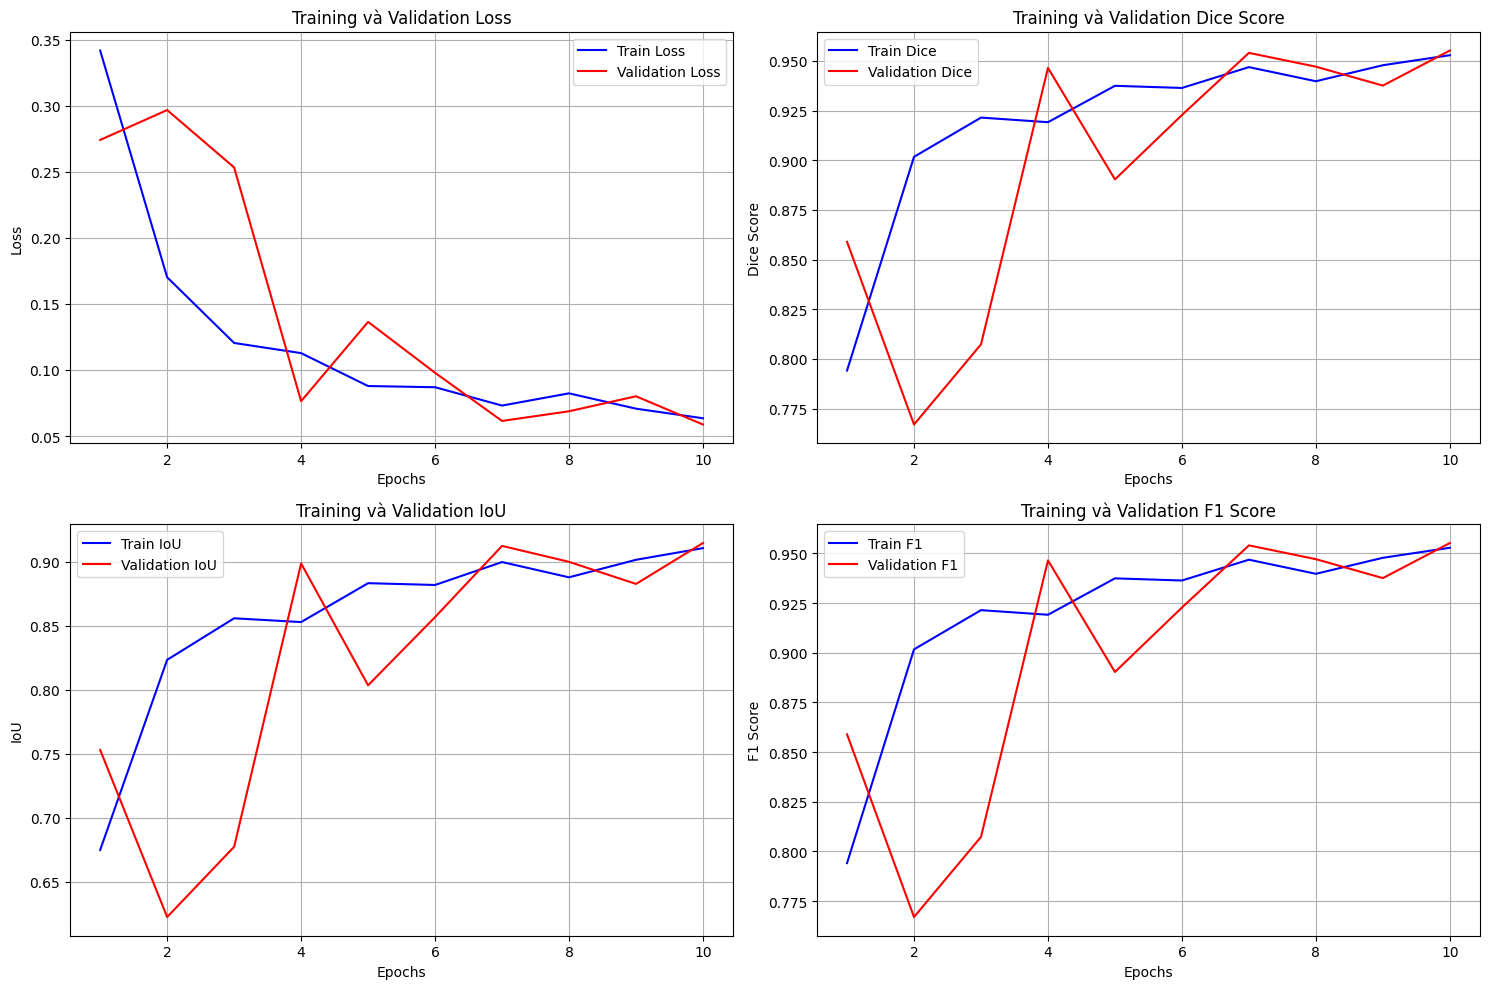

Kết quả training cuối cùng:
Best Validation Dice: 0.9552
Final Train Dice: 0.9528
Final Validation Dice: 0.9552


In [10]:
# Vẽ biểu đồ training history
def plot_training_history(history, save_path=None):
    """Vẽ biểu đồ lịch sử training"""
    
    epochs = range(1, len(history['train_losses']) + 1)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(epochs, history['train_losses'], 'b-', label='Train Loss')
    axes[0, 0].plot(epochs, history['val_losses'], 'r-', label='Validation Loss')
    axes[0, 0].set_title('Training và Validation Loss')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Dice Score
    axes[0, 1].plot(epochs, history['train_dices'], 'b-', label='Train Dice')
    axes[0, 1].plot(epochs, history['val_dices'], 'r-', label='Validation Dice')
    axes[0, 1].set_title('Training và Validation Dice Score')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Dice Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # IoU
    axes[1, 0].plot(epochs, history['train_ious'], 'b-', label='Train IoU')
    axes[1, 0].plot(epochs, history['val_ious'], 'r-', label='Validation IoU')
    axes[1, 0].set_title('Training và Validation IoU')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # F1 Score
    axes[1, 1].plot(epochs, history['train_f1s'], 'b-', label='Train F1')
    axes[1, 1].plot(epochs, history['val_f1s'], 'r-', label='Validation F1')
    axes[1, 1].set_title('Training và Validation F1 Score')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Biểu đồ đã được lưu tại: {save_path}")
    
    plt.show()
    
    # In kết quả cuối cùng
    print("Kết quả training cuối cùng:")
    print(f"Best Validation Dice: {history['best_val_dice']:.4f}")
    print(f"Final Train Dice: {history['train_dices'][-1]:.4f}")
    print(f"Final Validation Dice: {history['val_dices'][-1]:.4f}")

# Vẽ và lưu biểu đồ
plot_training_history(history, save_path=f'{OUTPUT_DIR}/plots/training_history.png')


In [27]:
# Lưu mô hình đã huấn luyện
model_path = f'{OUTPUT_DIR}/models/unet_local_model.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'training_history': history,
    'model_config': {
        'in_channels': 3,
        'out_channels': 1,
        'image_size': IMAGE_SIZE
    },
    'dataset_info': {
        'train_samples': len(train_files),
        'val_samples': len(val_files),
        'total_samples': len(valid_images)
    }
}, model_path)

print(f"Mô hình đã được lưu vào '{model_path}'")

# In tóm tắt kết quả cuối cùng
print("\n" + "="*60)
print("TÓM TẮT KẾT QUẢ CUỐI CÙNG")
print("="*60)
print(f"Best Validation Dice: {history['best_val_dice']:.4f}")
print(f"Final Train Dice: {history['train_dices'][-1]:.4f}")
print(f"Final Validation Dice: {history['val_dices'][-1]:.4f}")
print(f"Train samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")
print(f"Epochs trained: {NUM_EPOCHS}")
print(f"Model saved: {model_path}")
print(f"Results directory: {OUTPUT_DIR}")
print("="*60)


Mô hình đã được lưu vào '/media/nghia/Nguyen NghiaW/Lung/results/models/unet_local_model.pth'

TÓM TẮT KẾT QUẢ CUỐI CÙNG
Best Validation Dice: 0.9552
Final Train Dice: 0.9528
Final Validation Dice: 0.9552
Train samples: 203
Validation samples: 23
Epochs trained: 10
Model saved: /media/nghia/Nguyen NghiaW/Lung/results/models/unet_local_model.pth
Results directory: /media/nghia/Nguyen NghiaW/Lung/results


## **9. XAI - Explainable AI với GradCAM**


In [57]:
# Simple GradCAM Implementation (No hooks, reliable)
def create_gradcam(model, input_tensor):
    """
    Create GradCAM using input gradients only
    This approach avoids all hook-related issues
    """
    device = input_tensor.device
    
    # Enable gradients for input
    input_tensor.requires_grad_(True)
    
    # Forward pass
    output = model(input_tensor)
    
    # Use mean of output as target (for segmentation)
    target = output.mean()
    
    # Backward pass
    target.backward()
    
    # Get gradients w.r.t input
    gradients = input_tensor.grad
    
    # Global average pooling of gradients
    weights = gradients.mean(dim=(2, 3), keepdim=True)
    
    # Generate CAM by multiplying gradients with input
    cam = (gradients * weights).sum(dim=1, keepdim=True)
    
    # Apply ReLU and normalize
    cam = torch.relu(cam)
    if cam.max() > 0:
        cam = cam / cam.max()
    
    return cam.squeeze().detach().cpu().numpy()

print("Simple GradCAM function đã được định nghĩa")


Simple GradCAM function đã được định nghĩa


In [58]:
# Test Simple GradCAM
print("Testing Simple GradCAM...")
try:
    # Get a sample
    test_images, test_masks = next(iter(val_loader))
    test_images = test_images[:1].to(device)
    
    # Generate CAM
    cam = create_gradcam(model, test_images)
    
    print(f"✅ Simple GradCAM successful!")
    print(f"   - CAM shape: {cam.shape}")
    print(f"   - CAM range: [{cam.min():.4f}, {cam.max():.4f}]")
    
except Exception as e:
    print(f"❌ Simple GradCAM failed: {e}")
    import traceback
    traceback.print_exc()


Testing Simple GradCAM...
✅ Simple GradCAM successful!
   - CAM shape: (256, 256)
   - CAM range: [0.0000, 1.0000]


In [59]:
# Enhanced GradCAM Visualization with Better Contrast
def visualize_gradcam_enhanced(model, val_loader, device, num_samples=3, save_dir=None):
    """Enhanced GradCAM visualization with better contrast and visibility"""
    model.eval()
    torch.cuda.empty_cache()

    try:
        # Get a batch
        images, masks = next(iter(val_loader))
        images, masks = images.to(device), masks.to(device)

        # Predictions
        with torch.no_grad():
            predictions = model(images)

        # Move to CPU
        images_cpu = images.cpu()
        masks_cpu = masks.cpu()
        preds_cpu = predictions.cpu()

        # Select random samples
        indices = random.sample(range(len(images)), min(num_samples, len(images)))

        # Create figure
        fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))

        for i, idx in enumerate(indices):
            try:
                img = images_cpu[idx].permute(1, 2, 0).numpy()
                gt_mask = masks_cpu[idx].squeeze().numpy()
                pred_mask = preds_cpu[idx].squeeze().numpy()
                pred_binary = (pred_mask > 0.5).astype(np.uint8)

                # Generate GradCAM
                input_tensor = images[idx:idx+1].to(device)
                cam = create_gradcam(model, input_tensor)
                
                # Enhanced normalization with better contrast
                if cam.max() > cam.min():
                    # Use percentile-based normalization for better contrast
                    cam_min = np.percentile(cam, 5)  # Use 5th percentile instead of min
                    cam_max = np.percentile(cam, 95)  # Use 95th percentile instead of max
                    cam_norm = np.clip((cam - cam_min) / (cam_max - cam_min + 1e-8), 0, 1)
                else:
                    cam_norm = np.zeros_like(cam)

                # Apply gamma correction for better visibility
                cam_norm = np.power(cam_norm, 0.8)  # Gamma correction

                # Create enhanced overlay with better colormap
                # Use 'hot' colormap which is brighter and more visible
                heatmap = plt.cm.hot(cam_norm)[:, :, :3]
                
                # Better overlay ratio - more heatmap, less original image
                overlay_cam = 0.4 * img + 0.6 * heatmap
                overlay_cam = np.clip(overlay_cam, 0, 1)

                # Calculate Dice
                dice = calculate_dice(preds_cpu[idx:idx+1], masks_cpu[idx:idx+1])

                # Display
                col_titles = [
                    f"Ảnh gốc\nDice={dice:.3f}",
                    "Ground Truth",
                    "Prediction",
                    "GradCAM Heatmap",
                    "Overlay (Enhanced)"
                ]

                for j, data in enumerate([img, gt_mask, pred_mask, cam_norm, overlay_cam]):
                    ax = axes[i, j] if num_samples > 1 else axes[j]
                    if j in [1, 2]:  # grayscale for GT and prediction
                        ax.imshow(data, cmap='gray')
                    elif j == 3:  # GradCAM heatmap with hot colormap
                        ax.imshow(data, cmap='hot')
                    else:  # RGB images
                        ax.imshow(data)
                    ax.set_title(col_titles[j])
                    ax.axis('off')

                # Save individual images
                if save_dir is not None:
                    os.makedirs(save_dir, exist_ok=True)
                    save_path = os.path.join(save_dir, f"gradcam_enhanced_sample_{i+1}.png")
                    plt.imsave(save_path, overlay_cam)

            except Exception as e:
                print(f"Error processing sample {i+1}: {e}")
                continue

        plt.tight_layout()
        
        if save_dir:
            plt.savefig(f'{save_dir}/gradcam_enhanced_visualizations.png', dpi=300, bbox_inches='tight')
            print(f"📁 Đã lưu {len(indices)} ảnh GradCAM enhanced tại: {save_dir}")
        
        plt.show()
        
    except Exception as e:
        print(f"Error in enhanced GradCAM visualization: {e}")

print("Enhanced GradCAM visualization function đã được định nghĩa")


Enhanced GradCAM visualization function đã được định nghĩa


Running Enhanced GradCAM Visualization...
📁 Đã lưu 3 ảnh GradCAM enhanced tại: /media/nghia/Nguyen NghiaW/Lung/results/gradcam


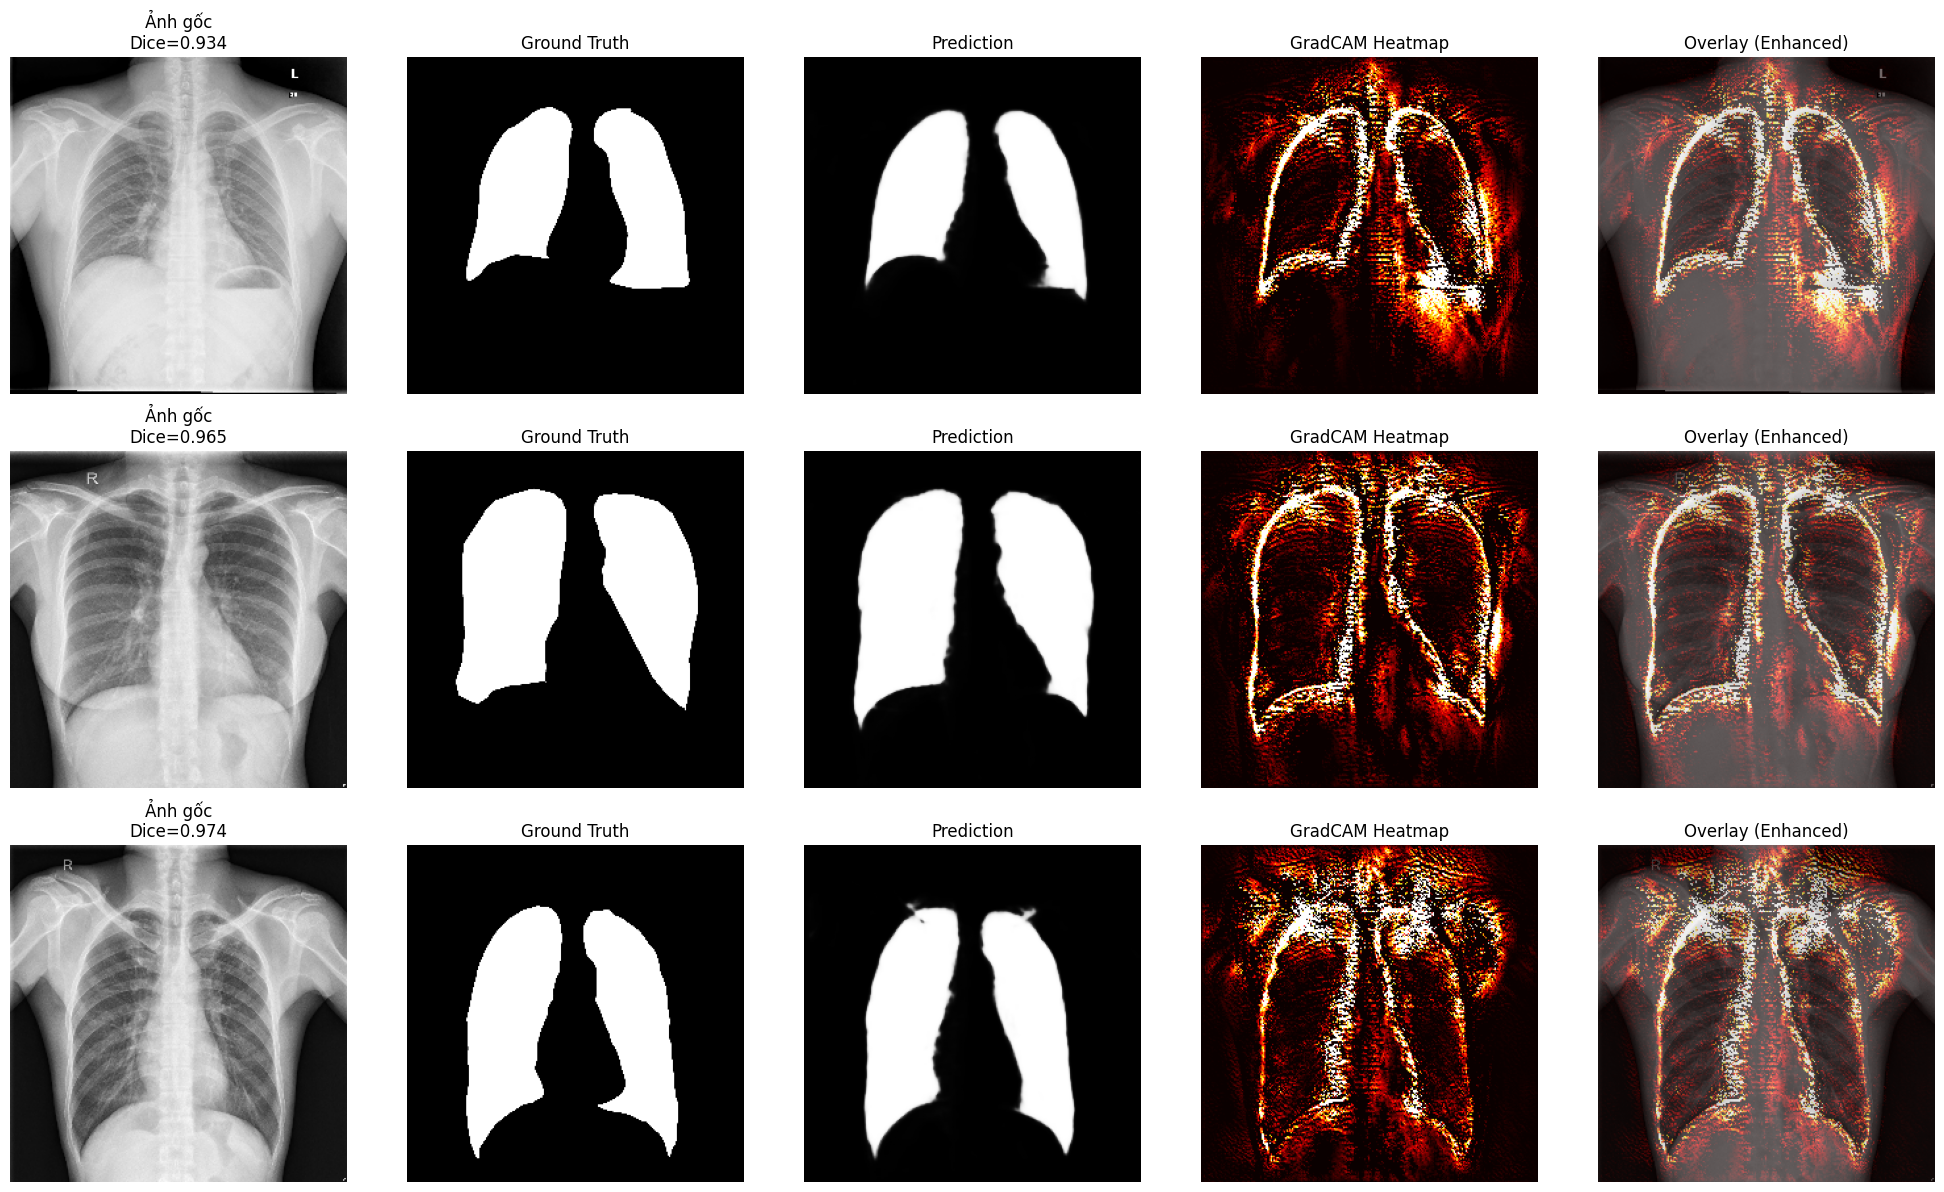

In [60]:
# Run Enhanced GradCAM Visualization
print("Running Enhanced GradCAM Visualization...")
visualize_gradcam_enhanced(model, val_loader, device, num_samples=3, save_dir=f'{OUTPUT_DIR}/gradcam')


GradCAM comparison function đã được định nghĩa
Running GradCAM Comparison...
📁 Đã lưu comparison visualization tại: /media/nghia/Nguyen NghiaW/Lung/results/gradcam


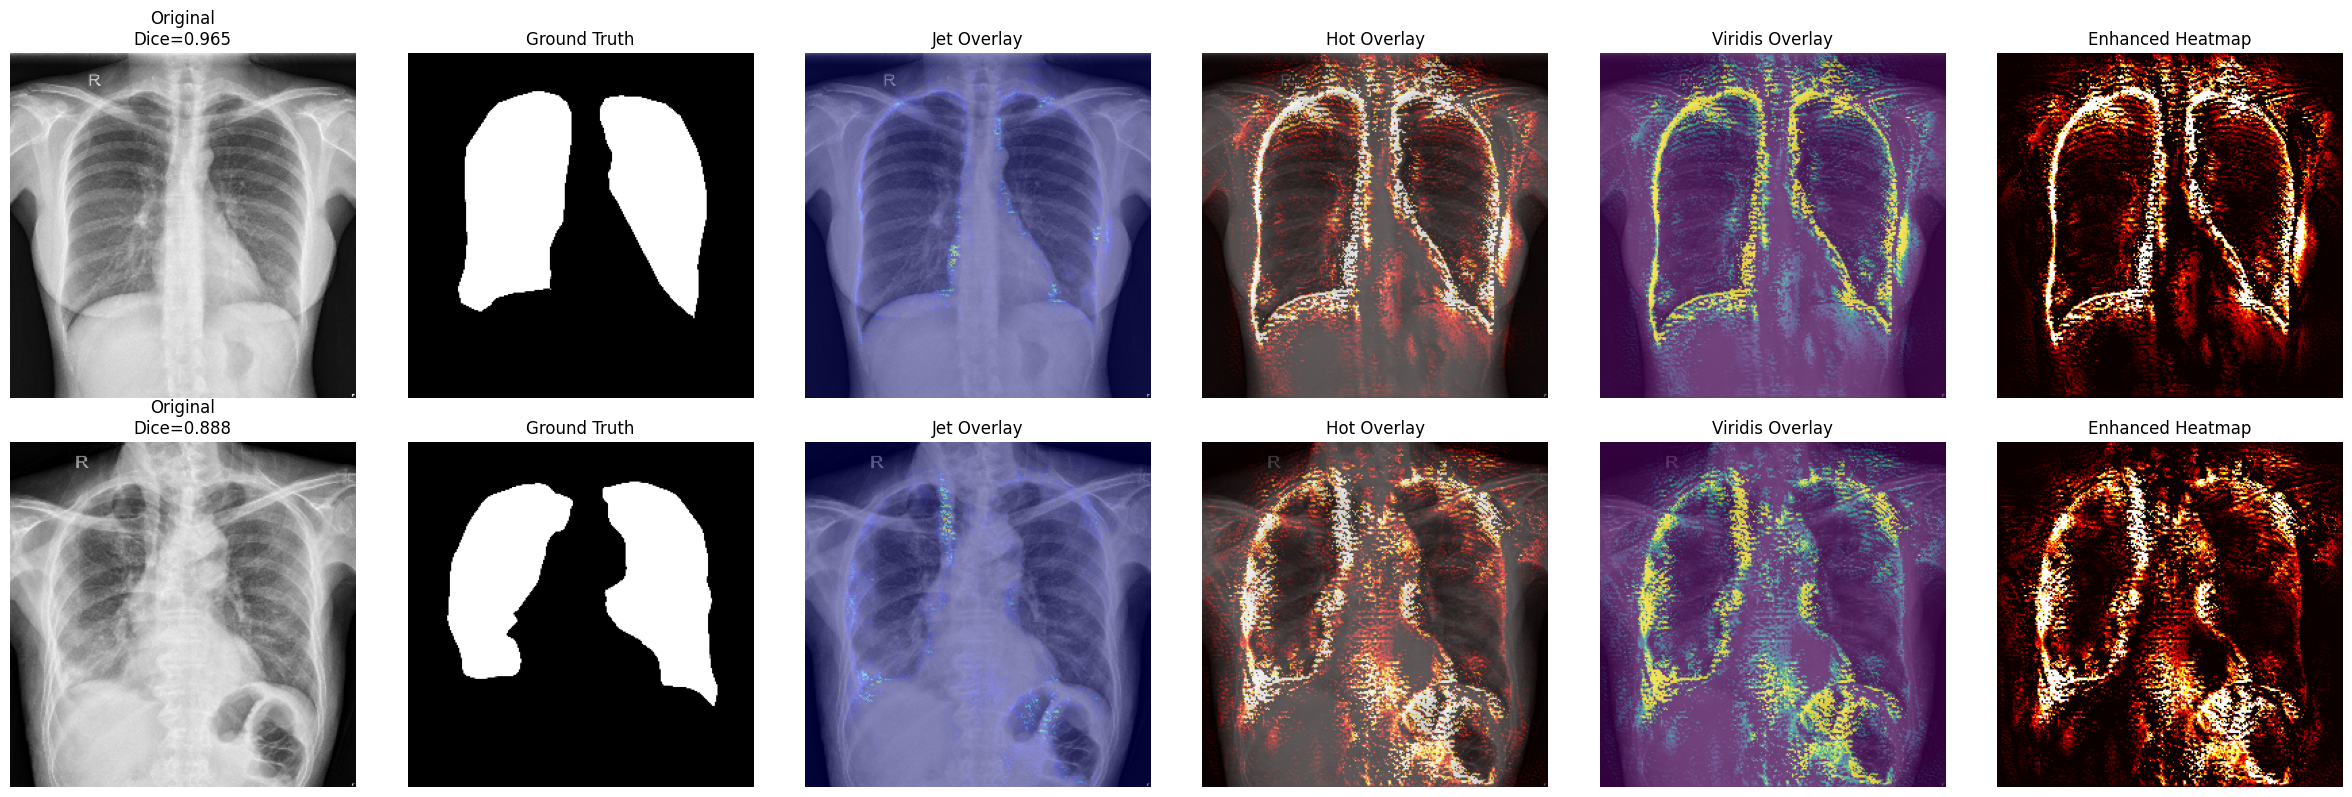

In [61]:
# Multiple GradCAM Visualization Options for Comparison
def visualize_gradcam_comparison(model, val_loader, device, num_samples=2, save_dir=None):
    """Compare different GradCAM visualization methods"""
    model.eval()
    torch.cuda.empty_cache()

    try:
        # Get a batch
        images, masks = next(iter(val_loader))
        images, masks = images.to(device), masks.to(device)

        # Predictions
        with torch.no_grad():
            predictions = model(images)

        # Move to CPU
        images_cpu = images.cpu()
        masks_cpu = masks.cpu()
        preds_cpu = predictions.cpu()

        # Select random samples
        indices = random.sample(range(len(images)), min(num_samples, len(images)))

        # Create figure with multiple visualization methods
        fig, axes = plt.subplots(num_samples, 6, figsize=(24, 4*num_samples))

        for i, idx in enumerate(indices):
            try:
                img = images_cpu[idx].permute(1, 2, 0).numpy()
                gt_mask = masks_cpu[idx].squeeze().numpy()
                pred_mask = preds_cpu[idx].squeeze().numpy()

                # Generate GradCAM
                input_tensor = images[idx:idx+1].to(device)
                cam = create_gradcam(model, input_tensor)
                
                # Method 1: Original normalization
                if cam.max() > cam.min():
                    cam_norm_orig = (cam - cam.min()) / (cam.max() - cam.min())
                else:
                    cam_norm_orig = np.zeros_like(cam)
                
                # Method 2: Percentile normalization
                if cam.max() > cam.min():
                    cam_min = np.percentile(cam, 5)
                    cam_max = np.percentile(cam, 95)
                    cam_norm_perc = np.clip((cam - cam_min) / (cam_max - cam_min + 1e-8), 0, 1)
                else:
                    cam_norm_perc = np.zeros_like(cam)
                
                # Method 3: Enhanced with gamma correction
                cam_norm_enhanced = np.power(cam_norm_perc, 0.8)

                # Create overlays with different methods
                # Original method (jet colormap)
                heatmap_jet = plt.cm.jet(cam_norm_orig)[:, :, :3]
                overlay_jet = 0.6 * img + 0.4 * heatmap_jet
                
                # Enhanced method (hot colormap)
                heatmap_hot = plt.cm.hot(cam_norm_enhanced)[:, :, :3]
                overlay_hot = 0.4 * img + 0.6 * heatmap_hot
                
                # Very bright method (viridis colormap)
                heatmap_viridis = plt.cm.viridis(cam_norm_enhanced)[:, :, :3]
                overlay_viridis = 0.3 * img + 0.7 * heatmap_viridis

                # Calculate Dice
                dice = calculate_dice(preds_cpu[idx:idx+1], masks_cpu[idx:idx+1])

                # Display
                col_titles = [
                    f"Original\nDice={dice:.3f}",
                    "Ground Truth",
                    "Jet Overlay",
                    "Hot Overlay", 
                    "Viridis Overlay",
                    "Enhanced Heatmap"
                ]

                data_list = [img, gt_mask, overlay_jet, overlay_hot, overlay_viridis, cam_norm_enhanced]
                
                for j, data in enumerate(data_list):
                    ax = axes[i, j] if num_samples > 1 else axes[j]
                    if j == 1:  # Ground truth
                        ax.imshow(data, cmap='gray')
                    elif j == 5:  # Enhanced heatmap
                        ax.imshow(data, cmap='hot')
                    else:  # RGB images
                        ax.imshow(data)
                    ax.set_title(col_titles[j])
                    ax.axis('off')

            except Exception as e:
                print(f"Error processing sample {i+1}: {e}")
                continue

        plt.tight_layout()
        
        if save_dir:
            plt.savefig(f'{save_dir}/gradcam_comparison.png', dpi=300, bbox_inches='tight')
            print(f"📁 Đã lưu comparison visualization tại: {save_dir}")
        
        plt.show()
        
    except Exception as e:
        print(f"Error in comparison visualization: {e}")

print("GradCAM comparison function đã được định nghĩa")

# Run comparison visualization
print("Running GradCAM Comparison...")
visualize_gradcam_comparison(model, val_loader, device, num_samples=2, save_dir=f'{OUTPUT_DIR}/gradcam')